## Make and view auditory spectrograms

In [1]:
from pathlib import Path
import os.path
import scipy.stats as stats
import numpy as np
import audspec 
from phonlab.utils import dir2df
import seaborn as sns

## Customize

In [2]:
# Where to find the .wav files and textgrids.
wavdir = Path(
    '/Users/kjohnson/Google Drive/xray_microbeam_database'
)
# Where to stash the spectrograms.
specdir = Path(
    '/Users/kjohnson/Google Drive/xray_microbeam_database/audspec'
)

fs = 22050     # The .wav files will be resampled to the rate specified by `fs`.
step = 0.003  # The frame step for the spectrogram, in seconds.
maxpatterson_coef = 100
rfftparams = {            # Params passed to rfft() in make_zgram()
    'overwrite_x': True,  # Try to reduce memory usage
    'workers': -1         # Use all CPUs
}

## Create the objects used in the analysis

In [3]:
# The Audspec to use for each of the .wav files.
aud = audspec.Audspec(fs, step_size=step, maxcbfiltn=maxpatterson_coef)

# Create image filters.
sharpen = aud.create_sharp_filter(span=6, mult=2)
blur = aud.create_blur_filter(span=3, sigma=3)



## Find files to analyze

In [4]:
wavdf = dir2df(wavdir, fnpat='\.wav$', addcols=['barename'])
print(f'Found {len(wavdf)} .wav files.')
wavdf

Found 6549 .wav files.


,relpath,fname,barename
0,JW11,ta001.wav,ta001
1,JW11,ta002.wav,ta002
2,JW11,ta003.wav,ta003
3,JW11,ta004.wav,ta004
4,JW11,ta005.wav,ta005
...,...,...,...
6544,JW63,tp115.wav,tp115
6545,JW63,tp116.wav,tp116
6546,JW63,tp117.wav,tp117
6547,JW63,tp117_2.wav,tp117_2


## Visualize the auditory representations

    lgram - lateral frequency suppression -- spectral differences are enhanced
    igram - integrated across frequencies -- energy is smeared across frequencies
    tgram - temporal gradient capturing sudden spectral changes.

Also here calculating an energy envelope for each type of *gram


/Users/kjohnson/Google Drive/xray_microbeam_database/JW25/tp074.wav
peak gradient of zgram envelope 162, peak in tgram envelope 160


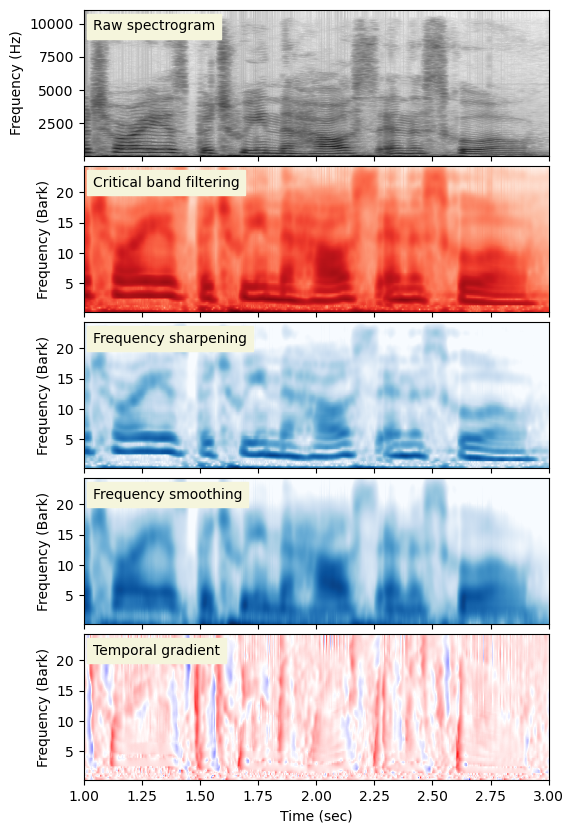

In [8]:
import matplotlib.pyplot as plt
import librosa
from mpl_toolkits.axes_grid1.axes_grid import Grid

%matplotlib inline

import IPython.display as ipd

s = np.random.randint(len(wavdf))      # pick a random file for illustration
wavfile = wavdir / wavdf['relpath'][s] / wavdf['fname'][s]
print(wavfile)

fs = 22050
data, _ = librosa.load(wavfile, sr=fs, mono=False)  # read data
if (data.shape[0]==2): data = data[0]                  # pick a channel if stereo

data = data[fs:fs+fs*2]  # two seconds, starting at 1 second
aud.make_zgram(data, rfftparams)   # critical band filtering

# derive three kinds of spectrogram
lgram = aud.apply_filt(aud.zgram, sharpen, axis=0, half_rectify=True)  # frequency sharpening
igram = aud.apply_filt(aud.zgram, blur, axis=0, half_rectify=True)  # frequency blurring
tgram = stats.zscore(np.gradient(aud.zgram,axis=0),axis=0)  # temporal change

# energy envelope  -- sum across spectrum
z_env = stats.zscore(np.sum(aud.zgram,axis=1))  # Zscore of sum energy across freq channels
t_env = stats.zscore(np.sum(tgram,axis=1))

z_grad = np.gradient(z_env)  # gradient of energy envelope
#t_env[t_env < 2] = 2   # limit to points that are > 2 sd above mean

zpeak = np.argmax(z_grad)
tpeak = np.argmax(t_env[2:-1])


fig = plt.figure(figsize=(6,10))
[ax1,ax2,ax3,ax4,ax5] = Grid(fig, rect=111, nrows_ncols=(5, 1),
            axes_pad=0.1, label_mode='L')
bgcolor = 'beige'

extent = (1.0,3.0,min(aud.fft_freqs),max(aud.fft_freqs))  # get the time and frequency values for indices.
ax1.imshow(20 * np.log(aud.spect.T), origin='lower', aspect='auto', 
           extent=extent, cmap = plt.cm.Greys)
ax1.set(xlabel="Time (sec)", ylabel="Frequency (Hz)")

extent = (1.0,3.0,min(aud.zfreqs),max(aud.zfreqs))  # get the time and frequency values for indices.
ax2.imshow(aud.zgram.T,origin='lower', aspect='auto', 
           extent=extent, cmap = plt.cm.Reds)
ax2.set(xlabel="Time (sec)", ylabel="Frequency (Bark)")

ax3.imshow(lgram.T, origin='lower', aspect='auto', 
           extent=extent, cmap = plt.cm.Blues)
ax3.set(xlabel="Time (sec)", ylabel="Frequency (Bark)")

ax4.imshow(igram.T, origin='lower', aspect='auto', 
           extent=extent, cmap = plt.cm.Blues)
ax4.set(xlabel="Time (sec)", ylabel="Frequency (Bark)")

ax5.imshow(tgram.T, origin='lower', aspect='auto',
           extent=extent, cmap = plt.cm.bwr)
ax5.set(xlabel="Time (sec)", ylabel="Frequency (Bark)")

ax1.text(1.04,9500,'Raw spectrogram',backgroundcolor=bgcolor)
ax2.text(1.04,21,'Critical band filtering',backgroundcolor=bgcolor)
ax3.text(1.04,21,'Frequency sharpening',backgroundcolor=bgcolor)
ax4.text(1.04,21,'Frequency smoothing',backgroundcolor=bgcolor)
ax5.text(1.04,21,'Temporal gradient',backgroundcolor=bgcolor)

#ax5a = ax5.twinx()
#ax5a.vlines(x = tpeak,ymin=np.min(t_env),ymax=np.max(t_env),color='r')
#ax5a.plot(t_env, 'k',linestyle="dotted") 
#ax5a.set_yticks([])
#fig.tight_layout()

print(f"peak gradient of zgram envelope {zpeak}, peak in tgram envelope {tpeak}")

ipd.Audio(data,rate=22050)   # put up the audio control object

In [ ]:
fig.savefig("example.png")

## Report how many new spec files will be created

The assumption here is that you don't want to over-write any 'audspec.npz' files that have already been created.

In [6]:
count = 0
for row in wavdf.itertuples():
    specname = specdir / row.relpath / f'{row.barename}.audspec.npz'
    
    if (os.path.isfile(specname)==False): 
        count=count+1
        
print(f'Out of {len(wavdf)} .wav files, {count} .audspec.npz files still need to be created.')

Out of 6549 .wav files, 6549 .audspec.npz files still need to be created.


## Create and cache spectrograms

Create the auditory spectrograms and save in a `.npz` file. The `aud` object contains the acoustic and auditory spectrograms already, and you don't need to do anything special to save them when you call `savez()`. You can create other variables to be saved and pass them as additional parameters to `savez()`.

In [7]:
count = 0
for row in wavdf.itertuples():
    # Create destination filename to be saved and create directory, if necessary.
    specname = specdir / row.relpath / f'{row.barename}.audspec.npz'
    
    if (os.path.isfile(specname)):   # if this audspec file was already created, you can skip it
        continue
    
    specname.resolve().parent.mkdir(parents=True, exist_ok=True)
    
    # Make the auditory spectrogram from .wav file.
    aud.make_zgram(
        wavdir / row.relpath / row.fname,
        rfftparams
    )

    # Apply image filters to the spectrogram.    
    lgram = aud.apply_filt(aud.zgram, sharpen, axis=0, half_rectify=True)  # frequency sharpening
    igram = aud.apply_filt(aud.zgram, blur, axis=0, half_rectify=True)  # frequency blurring
    tgram = stats.zscore(np.gradient(aud.zgram,axis=0),axis=0)  # temporal change


    # Save to disk, adding filtered auditory spectrograms.
    aud.savez(
        specname,
        igram=igram,   # Optional custom variables start from here.
        lgram=lgram,
        tgram=tgram
    )
    count=count+1
    
    if (count % 50 == 0):
        print(f'{count}. Saved {specname}')
    
    # Optional save to HDF5, adding filtered auditory spectrograms.
#    h5name = specdir / f'{row.barename}.audspec.h5'
#    aud.saveh5(
#        h5name,
#        igram=igram,   # Optional custom variables start from here.
#        lgram=lgram,
#        ogram=ogram,
#    )
#    print(f'Saved {h5name}.')

50. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW11/tp032.audspec.npz
100. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW11/tp082_2.audspec.npz
150. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW12/ta009.audspec.npz
200. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW12/tp042.audspec.npz
250. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW12/tp092.audspec.npz


/Users/kjohnson/miniconda3/envs/phonlab/lib/python3.10/site-packages/audspec.py:232: RuntimeWarning: invalid value encountered in divide
  agram = (agram - mymin) / (mymax - mymin)


300. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW13/tp007.audspec.npz
350. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW13/tp057.audspec.npz
400. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW13/tp106.audspec.npz
450. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW14/tp021.audspec.npz
500. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW14/tp070.audspec.npz
550. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW15/ta012.audspec.npz
600. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW15/tp042.audspec.npz
650. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW15/tp092.audspec.npz
700. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW16/tp007.audspec.npz
750. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW16/tp055.audspec.npz
800. Saved /Users/kjohnson/Google Drive/xray_micro

4600. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW502/ta008.audspec.npz
4650. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW502/tp037.audspec.npz
4700. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW502/tp087.audspec.npz
4750. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW51/ta016.audspec.npz
4800. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW51/tp046.audspec.npz
4850. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW51/tp095.audspec.npz
4900. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW52/tp006.audspec.npz
4950. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW52/tp056.audspec.npz
5000. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW52/tp106.audspec.npz
5050. Saved /Users/kjohnson/Google Drive/xray_microbeam_database/audspec/JW53/tp017.audspec.npz
5100. Saved /Users/kjohnson/Google Dr